# DFA on heart rates based on the age

This notebook performs DFA on the heart rate signals of various healthy subjects based on their age. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from tqdm import tqdm
import random

# Heart rate analysis
from wfdb import processing
import heartpy as hp
import wfdb
from MFDFA import MFDFA

import sys
sys.path.append('../')
import FractalAnalysis as fa

## Import data methods

The data used is available at the following url https://physionet.org/content/autonomic-aging-cardiovascular/1.0.0/

This data provides the ECG of more than 1000 healthy subjects that can be seperated into 15 different age groups: 1 (18-19 years), 2 (20-24 years), 3 (25-29 years), 4 (30-34 years), 5 (35-39 years), 6 (40-44 years), 7 (45-49 years), 8 (50-54 years), 9 (55-59 years), 10 (60-64 years), 11 (65-69 years), 12 (70-74 years), 13 (75-79 years), 14 (80-84 years), 15 (85-92 years). 

Along with the age, the following information are also provided: gender, recording device and BMI.

Some groups happened to be quite small (7 subjects). For this reason, some groups were brought together for some analysis in order to get groups with a larger number of subjects.

In [2]:
age_group = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
age_group2 = [['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9', '10', '11'], ['12', '13', '14', '15']] # Group together small age group with not enough subjects

In [3]:
def getIds(group, sex=2, BMI=0, device=2):
    """
    Finds the IDs of the subjects from a given age groups

    Parameters:
    - group: an age group(between 1 and 15) is a string
    - sex: the sex if a specific one needs to be considered (0 if male, 1 if female, 2 for both)
    - device: the device if a specific one needs to be considered (2 for both)
    - BMI: the BMI to be considered(0 if all BMI to be considered, otherwise between 1 and 4)

    Returns:
    - The list of the ids of the subjects in a given age group (an potential other parameters)
    """
    
    IDs = []
    with open('../subject-info.csv', newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            load = False
            if(row[1] == group):
                load=True
            else:
                continue
            if sex!=2:
                if str(sex)!=row[2]:
                    load=False
            if BMI!=0:
                if BMI==1:
                    if int(row[3]) > 18.5:
                        load=False
                if BMI==2:
                    if int(row[3]) < 18.5 or int(row[1]) > 24.9:
                        load=False
                if BMI==3:
                    if int(row[3]) < 25 or int(row[1]) > 29.9:
                        load=False
                if BMI==4:
                    if int(row[3]) < 30:
                        load=False
                    
            if device!=2:
                if str(sex)!=row[4]:
                    load=False
                
            if load==True:
                IDs.append(row[0])
                
    return IDs


# Same method but some age groups might be put together
def getIds2(group, sex=2, BMI=0, device=2):
    IDs = []
    with open('../subject-info.csv', newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            load = False
            if(row[1] in group):
                load=True
            else:
                continue
            if sex!=2:
                if str(sex)!=row[2]:
                    load=False
            if BMI!=0:
                if BMI==1:
                    if int(row[3]) > 18.5:
                        load=False
                if BMI==2:
                    if int(row[3]) < 18.5 or int(row[1]) > 24.9:
                        load=False
                if BMI==3:
                    if int(row[3]) < 25 or int(row[1]) > 29.9:
                        load=False
                if BMI==4:
                    if int(row[3]) < 30:
                        load=False
                    
            if device!=2:
                if str(sex)!=row[4]:
                    load=False
                
            if load==True:
                IDs.append(row[0])
                
    return IDs

# First version
def getHeartRates(subject):
    """
    For a given subject, returns its heart rate signal

    Parameters:
    - subject: the subject ID

    Returns:
    - The heart rate signal of the subject
    """

    path = '../ECG-data/' + subject
    record = wfdb.rdrecord(path, channels = [0])
    sig = record.p_signal
    peak_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=record.fs)
    hrs = hrs[~np.isnan(hrs)]
    return hrs

# Second version
def getHeartRates2(subject):
    """
    For a given subject, returns its heart rate signal

    Parameters:
    - subject: the subject ID

    Returns:
    - The heart rate signal of the subject
    """
    path = '../ECG-data/' + subject
    record = wfdb.rdrecord(path, channels = [0])
    signal = record.p_signal[:,0]
    sample_rate = 1000
    #wd, m = hp.process(signal, sample_rate)
    
    try:
        wd, m = hp.process(signal, sample_rate)
    except:
        return False, []
    
    peaks = wd['peaklist']
    tn = np.zeros(len(peaks)-1)
    
    for i in range(len(peaks)-2):
        tn[i+1] = peaks[i+1]-peaks[i]
        
    # Remove outliers
    tn = pd.DataFrame(tn)

    Q1 = np.percentile(tn, 25, interpolation= 'midpoint')
    Q3 = np.percentile(tn, 75, interpolation= 'midpoint')
    IQR = Q3 - Q1

    upper = np.where(tn >= (Q3+1.5*IQR))
    lower = np.where(tn <= (Q1-1.5*IQR))

    tn.drop(upper[0], inplace = True)
    tn.drop(lower[0], inplace = True)
    
    tn = tn.to_numpy()
    tn = [x[0] for x in tn]
    
    return True, tn

## DFA on age groups

In this section, DFA is applied to the subjects of the dataset and summarized based on the age group. The analysis can be made by
- considering all 15 groups
- grouping together the age groups containing a too small amount of subjects.

Some groups are very large compare to other. There is thus a possibility to:
- perform DFA on all the subjects of a group
- put a limit and perform DFA on the same amount of subjects per group

In [5]:
import warnings
warnings.filterwarnings('ignore')


Group 1
group size: 46


Loading...: 100%|██████████| 46/46 [00:58<00:00,  1.27s/it]


7 - 0098 could not be processed
27 - 0569 could not be processed
36 - 0850 could not be processed


Group 2
group size: 422


Loading...: 100%|██████████| 422/422 [07:50<00:00,  1.12s/it]


12 - 0031 could not be processed
37 - 0110 could not be processed
41 - 0121 could not be processed
50 - 0167 could not be processed
92 - 0300 could not be processed
95 - 0311 could not be processed
125 - 0389 could not be processed
148 - 0448 could not be processed
243 - 0698 could not be processed
309 - 0869 could not be processed
315 - 0891 could not be processed
315 - 0893 could not be processed
320 - 0902 could not be processed
344 - 0966 could not be processed


Group 3
group size: 229


Loading...: 100%|██████████| 229/229 [04:17<00:00,  1.12s/it]


2 - 0012 could not be processed
81 - 0421 could not be processed
98 - 0500 could not be processed
120 - 0609 could not be processed
126 - 0634 could not be processed
130 - 0671 could not be processed
147 - 0751 could not be processed
161 - 0816 could not be processed
200 - 1011 could not be processed


Group 4
group size: 105


Loading...: 100%|██████████| 105/105 [01:59<00:00,  1.13s/it]


35 - 0399 could not be processed
35 - 0405 could not be processed
56 - 0612 could not be processed
95 - 1051 could not be processed


Group 5
group size: 43


Loading...: 100%|██████████| 43/43 [00:55<00:00,  1.29s/it]




Group 6
group size: 50


Loading...: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


6 - 0186 could not be processed
18 - 0523 could not be processed
24 - 0604 could not be processed


Group 7
group size: 50


Loading...: 100%|██████████| 50/50 [01:06<00:00,  1.34s/it]


5 - 0092 could not be processed


Group 8
group size: 50


Loading...: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]




Group 9
group size: 18


Loading...: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


7 - 0365 could not be processed


Group 10
group size: 24


Loading...: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]




Group 11
group size: 19


Loading...: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


2 - 0214 could not be processed


Group 12
group size: 13


Loading...: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


4 - 0229 could not be processed
5 - 0293 could not be processed


Group 13
group size: 7


Loading...: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]




Group 14
group size: 12


Loading...: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


5 - 0587 could not be processed
10 - 1089 could not be processed


Group 15
group size: 7


Loading...: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]


4 - 0779 could not be processed



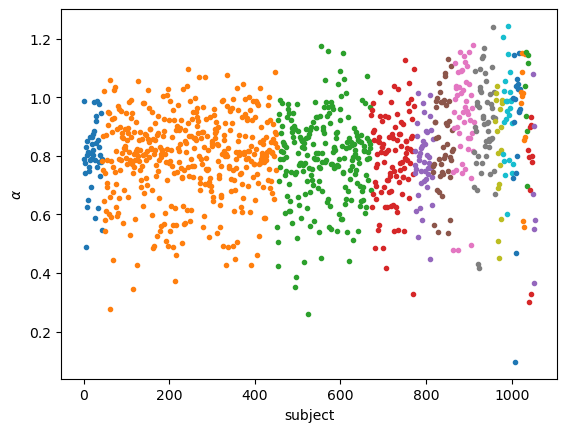

Maximum length  5240


In [6]:
method = getIds #getIds2 if put together small age groups
group = age_group #age_group2 put together small age groups
is_limit = False #Used to limit the number of subjects considered
limit = 30 # Limit of subjects considered
j = 0
sex=2
BMI=0

alphas_means = np.zeros(len(group)) # alphas coefficient with DFA method 1
alphas2_means = np.zeros(len(group)) # alphas coefficient with DFA method 2

lens = np.zeros(len(group)) # Contains the length of each group

# Used for the plot of all results
subject_num = 0
group_subjects = []

for g in group:
    print('\nGroup ' + str(j+1))

    # Get ids of subjects
    Ids = method(g)
    if is_limit:
        Ids = random.sample(Ids, limit)

   # Initialize variables     
    alphas = np.zeros(len(Ids))
    alphas2 = np.zeros(len(Ids))
    i = 0
    not_processed = "" # Prints the subjects whose heart rate signal couldn't be imported
    print('group size: ' + str(len(Ids)))
    lens[j] = len(Ids)
    
    alphas_all = [] # Used to plot the alpha coefficient of every subject in the age group
    group_subjects = []
    
    # Compute alpha for each subject
    for subject in tqdm(Ids, desc="Loading..."):
        loaded, heart_rates = getHeartRates2(subject)

        # The heart rate of the subject could be loaded
        if(loaded):
            # Version 1 of DFA
            alpha = fa.DFA(heart_rates, plot=False, limit_start = 3, limit_end=1000)
            #alpha = 0
            alphas[i] = alpha
            
            # Version 2 of DFA
            x = np.linspace(np.log(5), np.log(len(heart_rates)/8), 30)
            lag = np.exp(x).astype(int)
            alpha2 = fa.DFA2(np.array(heart_rates), lag)
            alphas2[i] = alpha2

            # For later plots
            subject_num += 1
            group_subjects.append(subject_num)
            alphas_all.append(alpha2)
            
            i = i + 1

        # The heart rate of the subject could not be loaded
        else:
            alphas = np.delete(alphas, len(alphas)-1)
            alphas2 = np.delete(alphas2, len(alphas2)-1)
            not_processed += str(i) + ' - ' + subject + ' could not be processed\n'
            lens[j] -= 1
    print(not_processed)
        
    
    alphas_means[j] = np.mean(alphas)
    alphas2_means[j] = np.mean(alphas2)
    
    j += 1
    
    plt.plot(group_subjects, alphas_all, '.')
    
    
plt.xlabel("subject")
plt.ylabel(r"$\alpha$")
plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


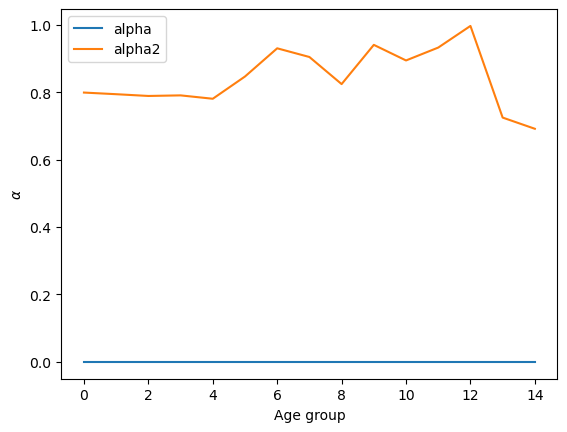

In [14]:
print(alphas_means)
plt.plot(alphas_means, label="alpha")
plt.plot(alphas2_means, label='alpha2')
plt.xlabel("Age group")
plt.ylabel(r"$\alpha$")
plt.legend()
plt.show()

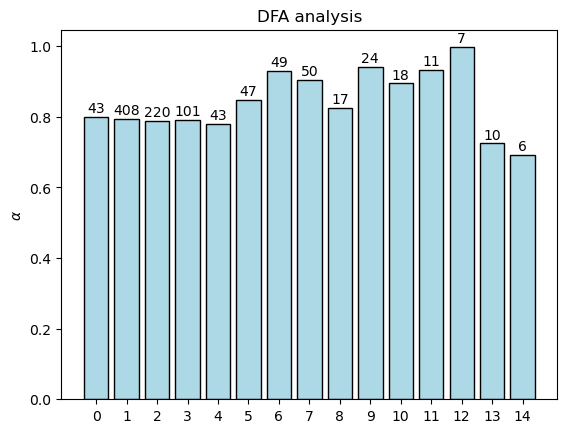

In [16]:
labels = []

for el in lens:
    labels.append(str(int(el)))

x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#x = [0,1,2,3,4,5,6,7,8,9]
width = 0.8 # width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, alphas2_means, width, color="lightblue", ec="black")

#ax.set_ylim(0,1.2)
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel("age group")
ax.set_title('DFA analysis')
ax.set_xticks(np.add(x,0)) # set the position of the x ticks
ax.set_xticklabels(x)

def autolabel(rects):
    # attach some text labels
    i=0
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height, labels[i], ha='center', va='bottom')
        i += 1

autolabel(rects1)

plt.show()

## DFA with various metrix

This is the exact same methodology except that various statistical measures will be used on the alpha coefficients of each groups

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
method = getIds #Can be getIds2
group = age_group #Can be age_group2
is_limit = True
limit = 7
j = 0

alphas_means = np.zeros(len(group))
alphas_var = np.zeros(len(group))
alphas_under_1 = np.zeros(len(group)) # Under 0.5
alphas_under_2 = np.zeros(len(group)) # Under 0.7
alphas_under_3 = np.zeros(len(group)) # Under 0.9
alphas_under_4 = np.zeros(len(group)) # Under 1.1
alphas_median = np.zeros(len(group))

lens = np.zeros(len(group))


for g in group:
    print('\nGroup ' + str(j+1))
    Ids = method(g)
    if is_limit:
        Ids = random.sample(Ids, limit)
    alphas = np.zeros(len(Ids))
    betas = np.zeros(len(Ids))
    i = 0
    not_processed = ""
    print('group size: ' + str(len(Ids)))
    lens[j] = len(Ids)
    for subject in tqdm(Ids, desc="Loading..."):
    #for subject in Ids:
        loaded, heart_rates = getHeartRates2(subject)
        if(loaded):
            alpha = fa.DFA(heart_rates, plot=False, limit_start = 3, limit_end=100)
            alphas[i] = alpha
            
            if alpha < 1.1:
                alphas_under_4[j] += 1
            if alpha < 0.9:
                alphas_under_3[j] += 1
            if alpha < 0.7:
                alphas_under_2[j] += 1
            if alpha < 0.5:
                alphas_under_1[j] += 1
            
            beta = fa.PowerSpectrumAnalysis(heart_rates, plot=False)
            betas[i] = beta
            i = i + 1
        else:
            alphas = np.delete(alphas, len(alphas)-1)
            betas = np.delete(betas, len(betas)-1)
            not_processed += str(i) + ' - ' + subject + ' could not be processed\n'
            lens[j] -= 1
    print(not_processed)
        
    
    alphas_means[j] = np.mean(alphas)
    alphas_var[j] = np.var(alphas)
    alphas_median[j] = np.percentile(alphas, 50, interpolation= 'midpoint')
    alphas_under_1[j] /= lens[j]
    alphas_under_2[j] /= lens[j]
    alphas_under_3[j] /= lens[j]
    alphas_under_4[j] /= lens[j]
    
    j += 1



Group 1
group size: 7


Loading...: 100%|██████████| 7/7 [00:14<00:00,  2.06s/it]




Group 2
group size: 7


Loading...: 100%|██████████| 7/7 [00:14<00:00,  2.05s/it]




Group 3
group size: 7


Loading...: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]




Group 4
group size: 7


Loading...: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]




Group 5
group size: 7


Loading...: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]




Group 6
group size: 7


Loading...: 100%|██████████| 7/7 [00:12<00:00,  1.73s/it]




Group 7
group size: 7


Loading...: 100%|██████████| 7/7 [00:16<00:00,  2.40s/it]




Group 8
group size: 7


Loading...: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]




Group 9
group size: 7


Loading...: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]




Group 10
group size: 7


Loading...: 100%|██████████| 7/7 [00:12<00:00,  1.79s/it]




Group 11
group size: 7


Loading...: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]




Group 12
group size: 7


Loading...: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


1 - 0229 could not be processed
4 - 0293 could not be processed


Group 13
group size: 7


Loading...: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]




Group 14
group size: 7


Loading...: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]




Group 15
group size: 7


Loading...: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

5 - 0779 could not be processed



### Result graphs

In [ ]:
def statistics_bar_plot(x, alphas, ylabel):

    width = 0.8 # width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, alphas, width, color="lightblue", ec="black")

    #ax.set_ylim(0,1.2)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.add(x,(width/2))) # set the position of the x ticks
    ax.set_xticklabels(x)

    def autolabel(rects):
        # attach some text labels
        i=0
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.005*height, labels[i], ha='center', va='bottom')
            i += 1

    autolabel(rects1)

    plt.show()

In [9]:
labels = []

for el in lens:
    labels.append(str(int(el)))

#### Means

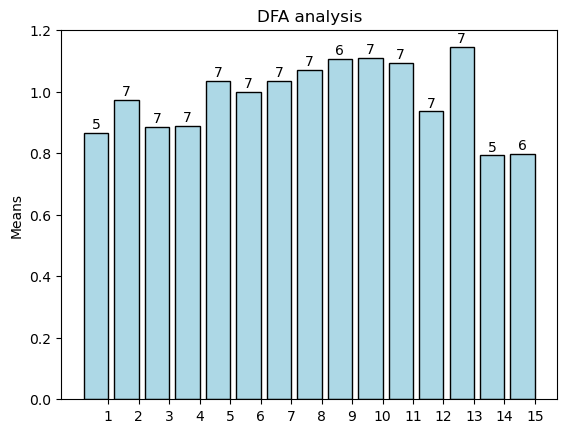

In [10]:
statistics_bar_plot(x, alphas_means, r"Mean of $\alpha$")

#### Variance

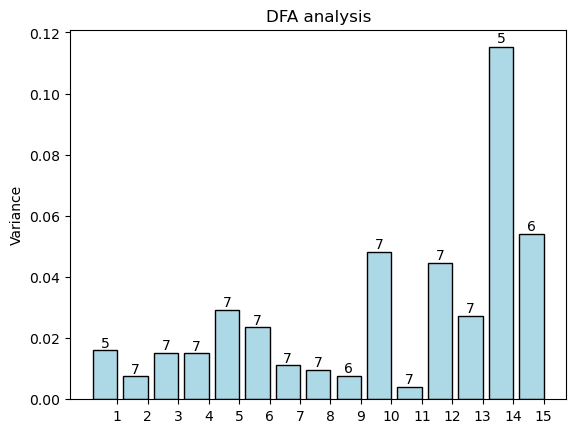

In [11]:
statistics_bar_plot(x, alphas_var, r"Variance of $\alpha$")

#### Median

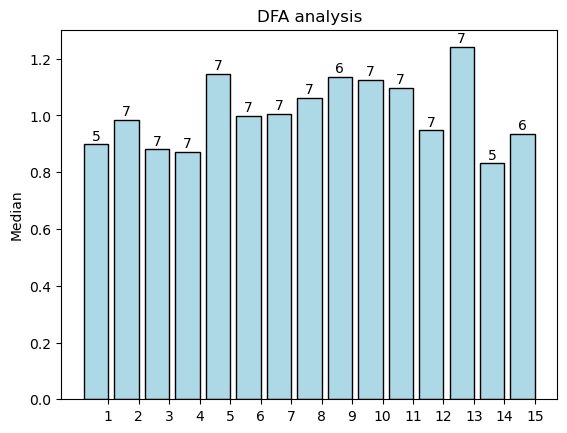

In [12]:
statistics_bar_plot(x, alphas_median, r"Median of $\alpha$")

#### Proportion under 0.5

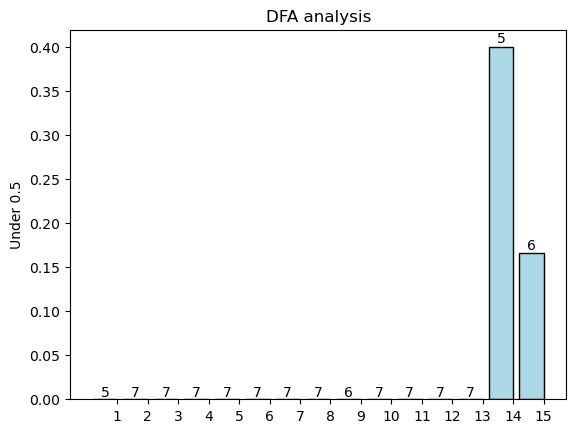

In [13]:
statistics_bar_plot(x, alphas_under_1, r"Proportion of subjects with $\alpha$ < 0.5")

#### Proportion under 0.7

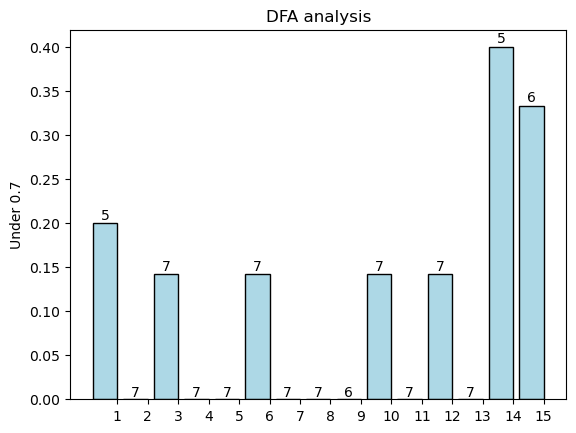

In [14]:
statistics_bar_plot(x, alphas_under_2, r"Proportion of subjects with $\alpha$ < 0.7")

#### Proportion under 0.9

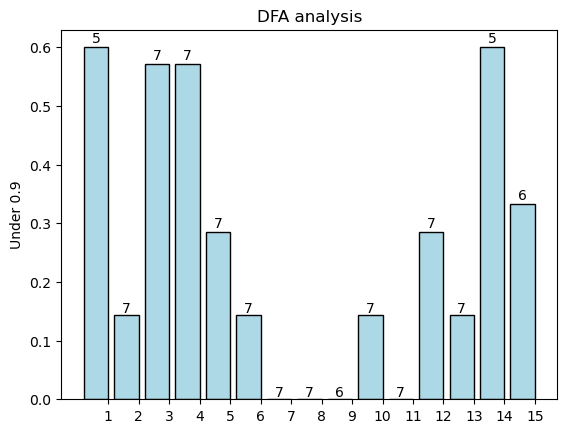

In [15]:
statistics_bar_plot(x, alphas_under_3, r"Proportion of subjects with $\alpha$ < 0.9")

#### Proportion under 1.1

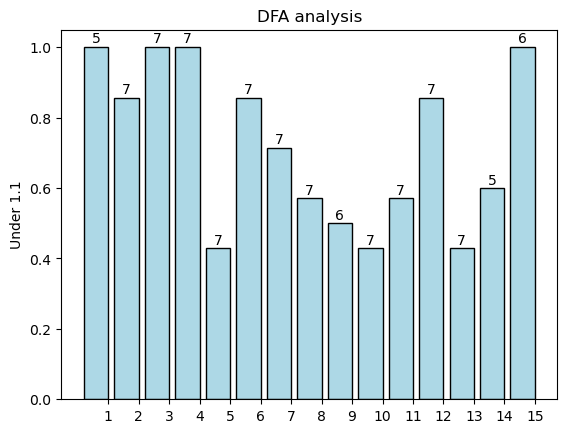

In [16]:
statistics_bar_plot(x, alphas_under_4, r"Proportion of subjects with $\alpha$ < 1.1")

## Various scales
This is once again the same method, except that this time, the impact of considering a small or large scale in the DFA method is analysed

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
method = getIds2 #Can be getIds2
group = age_group2 #Can be age_group2
is_limit = True
limit = 30
j = 0

alphas_1 = np.zeros(len(group))
alphas_2 = np.zeros(len(group))
alphas_3 = np.zeros(len(group))
alphas_4 = np.zeros(len(group))

lens = np.zeros(len(group))


for g in group:
    print('\nGroup ' + str(j+1))
    Ids = method(g)
    if is_limit:
        Ids = random.sample(Ids, limit)
    alphas1 = np.zeros(len(Ids))
    alphas2 = np.zeros(len(Ids))
    alphas3 = np.zeros(len(Ids))
    alphas4 = np.zeros(len(Ids))
    i = 0
    not_processed = ""
    print('group size: ' + str(len(Ids)))
    lens[j] = len(Ids)
    for subject in tqdm(Ids, desc="Loading..."):
    #for subject in Ids:
        loaded, heart_rates = getHeartRates2(subject)
        if(loaded):
            #print(len(heart_rates))
            alphas1[i] = fa.DFA(heart_rates, plot=False, limit_start = 3, limit_end=50)
            alphas2[i] = fa.DFA(heart_rates, plot=False, limit_start = 3, limit_end=100)
            alphas3[i] = fa.DFA(heart_rates, plot=False, limit_start = 3, limit_end=500)
            alphas4[i] = fa.DFA(heart_rates, plot=False, limit_start = 3, limit_end=1000)

            i = i + 1
        else:
            alphas1 = np.delete(alphas1, len(alphas1)-1)
            alphas2 = np.delete(alphas2, len(alphas2)-1)
            alphas3 = np.delete(alphas3, len(alphas3)-1)
            alphas4 = np.delete(alphas4, len(alphas4)-1)
            not_processed += str(i) + ' - ' + subject + ' could not be processed\n'
            lens[j] -= 1
    print(not_processed)
        
    
    alphas_1[j] = np.mean(alphas1)
    alphas_2[j] = np.mean(alphas2)
    alphas_3[j] = np.mean(alphas3)
    alphas_4[j] = np.mean(alphas4)
    
    j += 1


Group 1
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [01:33<00:00,  3.12s/it]




Group 2
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [01:35<00:00,  3.19s/it]


2 - 0110 could not be processed


Group 3
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [01:15<00:00,  2.50s/it]


5 - 0609 could not be processed
11 - 0012 could not be processed


Group 4
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [01:17<00:00,  2.59s/it]


20 - 0405 could not be processed


Group 5
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [01:29<00:00,  2.98s/it]




Group 6
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [01:21<00:00,  2.72s/it]


14 - 0186 could not be processed


Group 7
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [01:43<00:00,  3.45s/it]




Group 8
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [01:34<00:00,  3.14s/it]




Group 9
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [01:24<00:00,  2.80s/it]


9 - 0214 could not be processed
26 - 0365 could not be processed


Group 10
group size: 30


Loading...: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [00:58<00:00,  1.95s/it]

10 - 0587 could not be processed
13 - 0779 could not be processed
26 - 1089 could not be processed



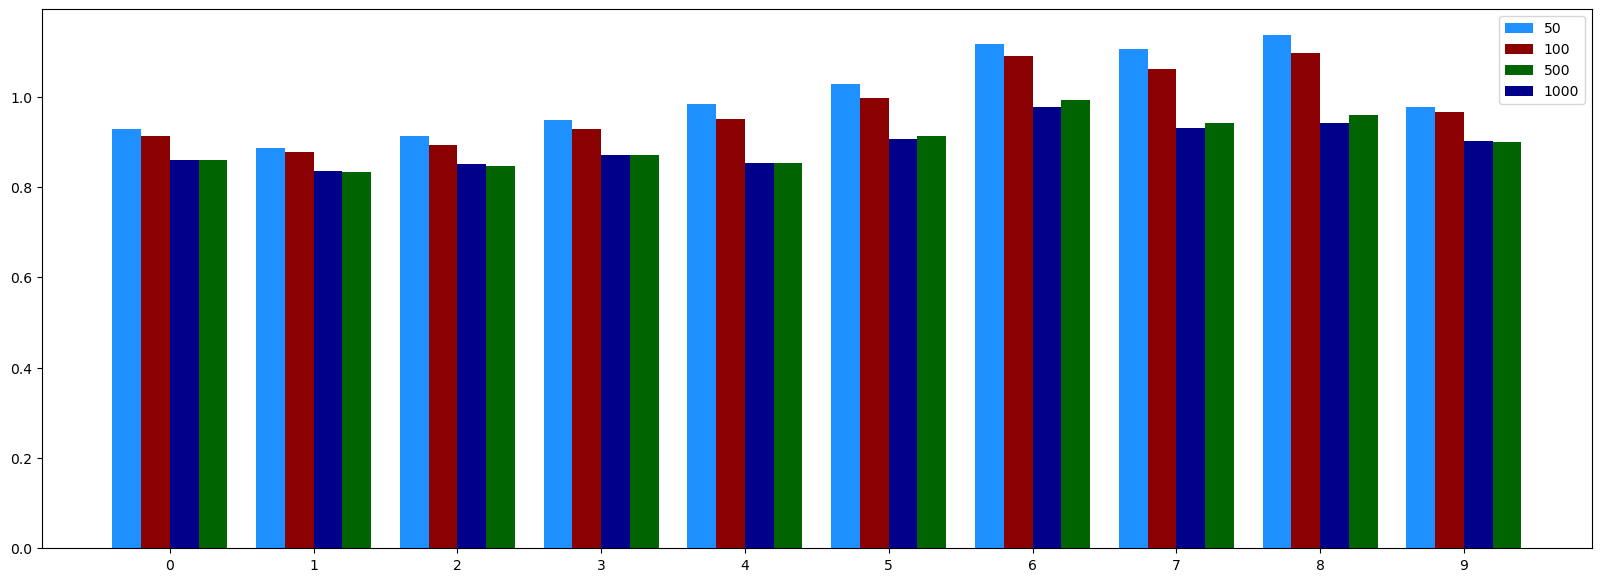

In [23]:
x = np.arange(len(alphas_1))
width = 0.2

fig, ax = plt.subplots(figsize=(20, 7))
bar1 = ax.bar(x - 3*width/2, alphas_1, width, label='50', color='dodgerblue')
bar2 = ax.bar(x - width/2, alphas_2, width, label='100', color='darkred')
bar3 = ax.bar(x + 3*width/2, alphas_3, width, label='500', color='darkgreen')
bar4 = ax.bar(x + width/2, alphas_4, width, label='1000', color='darkblue')

#for rect in bar1 + bar2 + bar3 + bar4:
#    height = rect.get_height()
#    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

ax.set_xticks(x)
#ax.set_xticklabels(results)
ax.legend()



plt.show()

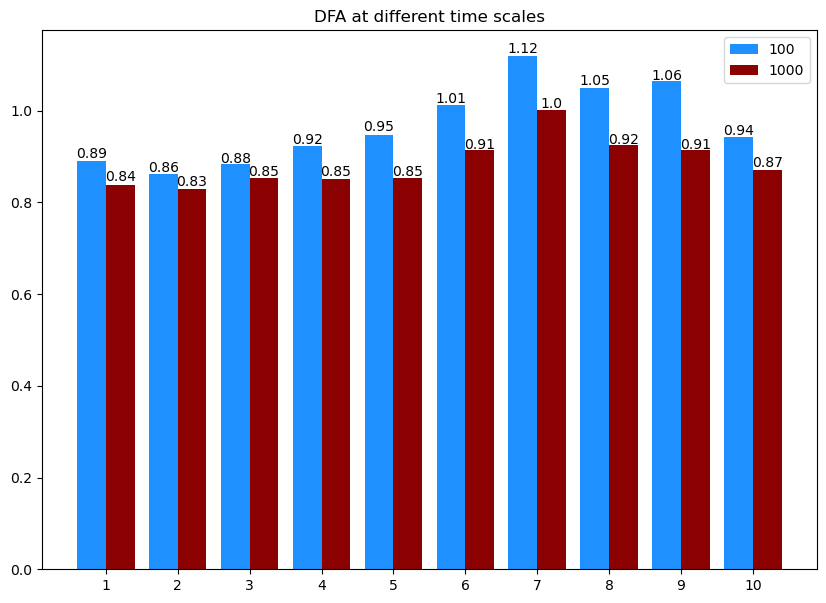

In [56]:
x = np.arange(1, len(alphas_2)+1)
width = 0.4

fig, ax = plt.subplots(figsize=(10, 7))
bar1 = ax.bar(x - width/2, alphas_2, width, label='100', color='dodgerblue')
bar2 = ax.bar(x + width/2, alphas_4, width, label='1000', color='darkred')

for rect in bar1 + bar2:
    height = round(rect.get_height(), 2)
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

ax.set_xticks(x)
#ax.set_xticklabels(results)
ax.set_title('DFA at different time scales')
ax.legend()



plt.show()

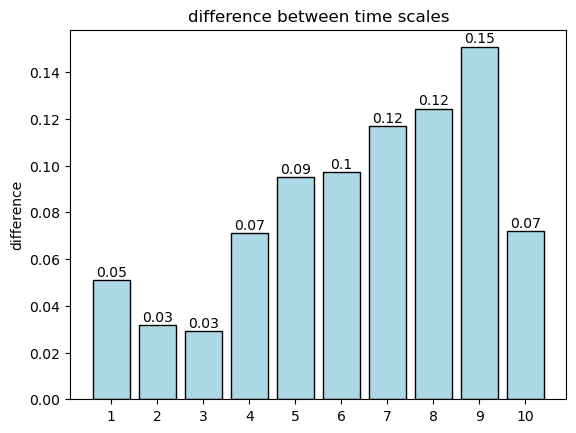

In [40]:
fig, ax = plt.subplots()
y = alphas_2 - alphas_4
rects1 = ax.bar(x, y, width, color="lightblue", ec="black")
width = 0.8

#ax.set_ylim(0,1.2)
ax.set_ylabel('difference')
ax.set_title('Difference between time scales')
ax.set_xticks(np.add(x,0)) # set the position of the x ticks
ax.set_xticklabels(x)

def autolabel(rects):
    # attach some text labels
    i=0
    for rect in rects:
        height1 = rect.get_height()
        height2 = round(rect.get_height(), 2)
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height1, height2, ha='center', va='bottom')
        i += 1

autolabel(rects1)

plt.show()